In [1]:
import sys
sys.path.insert(1, '..')
from utils import timeSteps2stepSize
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random
import flax
from flax import linen as nn
import optax

import time

import os
import pickle

import matplotlib.pyplot as plt

from torch.utils import data
from torch.utils.data import Dataset

# print("the device used is", jax.devices(), jax.default_backend())
# print(jax.device_count())

/home/roland/miniconda3/envs/my_diffusion/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/roland/miniconda3/envs/my_diffusion/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
seed = 0
key = random.PRNGKey(seed)
rng = key
batch_size = 512
intermediate_embeding_time_dimension = 128
intermediate_features_embedding = 128
# epsilon = 0.01 # smallest time considered
num_timesteps = 2000

dimension = 2
T_max = 1.0

num_training_iterations = 100_000

print("the device used is", jax.devices(), jax.default_backend())
print(jax.device_count())

2023-06-09 17:41:21.636545: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


the device used is [CpuDevice(id=0)] cpu
1


In [3]:
def generateBatchPoints(key, distribution = 'plus_sign', batch_size=batch_size) :
    if distribution == 'spiral' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)**.5
        noise = 0.01*random.normal(key2, shape = (batch_size,2))
        angle = 10*radius # angle from the first axis
        positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise
    
    if distribution == 'plus_sign' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= -1., maxval= 1.)
        axis = random.randint(key2, shape  = (batch_size,1), minval=0, maxval=2)
        positions = jnp.concatenate( (radius*axis,radius*(1 - axis)), axis=1  )

    return(positions[...,None])

class distribution_dataset(Dataset):
    def __init__(self, key = random.PRNGKey(seed)) : 

        self.points = generateBatchPoints(key, distribution = 'spiral', batch_size = batch_size*50 )

    def __len__(self):
        return self.points.shape[0]//batch_size 

    def __getitem__(self, idx):
        return( self.points[ idx*batch_size:(idx+1)*batch_size , ...])
    
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                  shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0,
                  pin_memory=False, drop_last=False,
                  timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [4]:
rng , subkey = random.split(key)
trainset = distribution_dataset(subkey)
train_dataloader = NumpyLoader(trainset, batch_size=1, shuffle=True)

In [5]:
beta = 6.0
net_width = 128 
Gamma = 0.
Sigma_xx_0 = 0.05
Sigma_vv_0 = 0.25


M = 0.25 # Magic value from paper 
nu = 2*jnp.sqrt(M**(-1)) + Gamma # Critically or Non critically damped regime
BETA = lambda t : t*beta
print(" values    :   nu ",nu,"  Gamma ",Gamma,"  M ",M)
if 4*M**(-1) != (Gamma - nu)**2 :
    print("NON CRITICALLY DAMPED REGIME !!")
else :
    print("CRITICALLY DAMPED REGIME !!")


 values    :   nu  4.0   Gamma  0.0   M  0.25
CRITICALLY DAMPED REGIME !!


In [6]:
def timeIndices2RealTime(time_indices ) :
    return( time_indices *1.0/num_timesteps)

In [7]:
# defining the Sigma in a non-critical general way. We use different notations here.

# TODO change those values they are arbitrary 



# check if we are in the critically damped regime
if 4*M**(-1) != (Gamma - nu)**2 :
    Sigma_xx = lambda t : (1/(2*M*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(2*jnp.exp((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma+ nu)))/(2*M))*M*(-4 + M*(Gamma- nu)**2) + 2*Sigma_vv_0 - 4*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + M*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma- nu))*(Gamma- nu)*(-1 + Sigma_xx_0) - 2*M*Sigma_xx_0 + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/ M)*(2*Sigma_vv_0 - M*(Gamma- nu)*(jnp.sqrt( M*(-4 + M*(Gamma- nu)**2)) + M*(-Gamma+ nu))*(-1 + Sigma_xx_0) - 2*M*Sigma_xx_0))
    Sigma_xv = lambda t : (1/(2*M*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(-jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_vv_0 + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_vv_0 + M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) - 2*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + M*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_xx_0 -jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*M*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_xx_0)
    Sigma_vv = lambda t : -(1/(2*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(-2*jnp.exp((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma+ nu)))/(2*M))*M*(-4 + M*(Gamma- nu)**2) + M**2*(Gamma- nu)**2 + (2 + jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*(Gamma- nu))*Sigma_vv_0 + 4*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) - M*((Gamma- nu)*(jnp.sqrt( M*(-4 + M*(Gamma- nu)**2)) + Gamma*Sigma_vv_0 - nu*Sigma_vv_0) + 2*Sigma_xx_0) + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*(M**2*(Gamma- nu)**2 + 2*Sigma_vv_0 + jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*(-Gamma+ nu)*Sigma_vv_0 + M*(Gamma- nu)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) - Gamma*Sigma_vv_0 + nu*Sigma_vv_0) - 2*M*Sigma_xx_0))

    Cov_xx = lambda s,t : (1/(2 *(-4 + M *(Gamma - nu)**2))) *jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M* (Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M)))) *(4 *jnp.exp(( BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) + 4 *jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) + jnp.exp(( BETA(s) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) + jnp.sqrt(M) *(Gamma + nu)))/( 2 *jnp.sqrt(M))) *(-4 +jnp.sqrt(M) *jnp.sqrt(-4 +M *(Gamma - nu)**2) *(Gamma - nu) +M *(Gamma - nu)**2) - jnp.sqrt(M) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma - nu)) *(Gamma - nu) + jnp.exp(((BETA(s) + BETA(t)) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) *jnp.sqrt( M) *(Gamma - nu) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(-Gamma + nu)) + jnp.exp(1/2 *((BETA(t)* jnp.sqrt(-4 + M *(Gamma - nu)**2))/jnp.sqrt(M) + BETA(s)* (Gamma + nu))) *(-4 +M *(Gamma - nu)**2 +jnp.sqrt(M) *jnp.sqrt(-4 +M *(Gamma - nu)**2) *(-Gamma + nu))) + ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M)))) *(-1 + jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *(-1 + jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *Sigma_vv_0)/( M *(-4 + M *(Gamma - nu)**2)) + ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M)))) *(-2 - 2 *jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) - 2 *jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) + jnp.sqrt(M) *jnp.sqrt(-4 +M *(Gamma - nu)**2) *(Gamma - nu) + M *(Gamma - nu)**2 + jnp.exp(((BETA(s) + BETA(t)) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) *(-2 + M *(Gamma - nu)**2 +jnp.sqrt(M) *jnp.sqrt(-4 +M *(Gamma - nu)**2) *(-Gamma + nu))) *Sigma_xx_0)/(2 *(-4 + M *(Gamma - nu)**2))
    Cov_xv = lambda s,t : ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M* (Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M)))) *(-((jnp.exp(( BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) - jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2* jnp.sqrt(M))))*(-1 + jnp.exp( 1/2 *BETA(s) *(Gamma + nu))) *jnp.sqrt(M)*jnp.sqrt(-4 + M *(Gamma - nu)**2)) - (-1 + jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *(-1 + jnp.exp((  BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *M *(Gamma - nu)))/(-4 +M *(Gamma - nu)**2) + ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M)))) *(-1 + jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *((1 + jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *jnp.sqrt(-4 +M *(Gamma - nu)**2) + (-1 + jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *jnp.sqrt( M) *(Gamma - nu)) *Sigma_vv_0)/( 2 *jnp.sqrt(M) *(-4 + M *(Gamma - nu)**2)) + ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M))))* (-1 + jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *jnp.sqrt(  M) *(-((1 + jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M)))) *jnp.sqrt(-4 + M *(Gamma - nu)**2)) + (-1 + jnp.exp((  BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *jnp.sqrt( M) *(Gamma - nu)) *Sigma_xx_0)/( 2 *(-4 + M *(Gamma - nu)**2))
    Cov_vv = lambda s,t : (1/(2 *(-4 + M *(Gamma - nu)**2))) *jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M))))*M *(4 *jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) + 4 *jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) + jnp.exp(1/2 *((BETA(t)* jnp.sqrt(-4 + M *(Gamma - nu)**2))/jnp.sqrt(M) + BETA(s) *(Gamma + nu))) *(-4 +jnp.sqrt(M) *jnp.sqrt(-4 +M *(Gamma - nu)**2) *(Gamma - nu) +M *(Gamma - nu)**2) - jnp.exp(((BETA(s) + BETA(t)) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) *jnp.sqrt( M) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma - nu)) *(Gamma - nu) + jnp.sqrt(M) *(Gamma - nu) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(-Gamma + nu)) + jnp.exp((BETA(s)* (jnp.sqrt(-4 + M *(Gamma - nu)**2) + jnp.sqrt(M) *(Gamma + nu)))/( 2 *jnp.sqrt(M))) *(-4 + M *(Gamma - nu)**2 +jnp.sqrt(M) *jnp.sqrt(-4 +M *(Gamma - nu)**2) *(-Gamma + nu))) + ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M)* (Gamma + nu)))/(4 *jnp.sqrt(M)))) *(-2 - 2 *jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) - 2 *jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) + jnp.exp(((BETA(s) + BETA(t)) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M))) *(-2 +jnp.sqrt(M) *jnp.sqrt(-4 +M *(Gamma - nu)**2)* (Gamma - nu) +M *(Gamma - nu)**2) + M *(Gamma - nu)**2 + jnp.sqrt(M) *jnp.sqrt(-4 +M *(Gamma - nu)**2) *(-Gamma + nu)) *Sigma_vv_0)/(2 *(-4 + M *(Gamma - nu)**2)) + ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M)))) *(-1 + jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *(-1 + jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *M *Sigma_xx_0)/(-4 +M *(Gamma - nu)**2)
    Cov_vx = lambda s,t : ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M)* (Gamma + nu)))/(4 *jnp.sqrt(M)))) *((jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M))) - jnp.exp((  BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2* jnp.sqrt(M)))) *(-1 + jnp.exp(1/2 *BETA(s) *(Gamma + nu))) *jnp.sqrt(M) * jnp.sqrt(-4 +M* (Gamma - nu)**2) - (-1 + jnp.exp((BETA(s)* jnp.sqrt(-4 + M* (Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *(-1 + jnp.exp((  BETA(t)* jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *M *(Gamma - nu)))/(-4 +M *(Gamma - nu)**2) + ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M)))) *(-1 + jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M))))* ((1 + jnp.exp((  BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *jnp.sqrt(-4 +M *(Gamma - nu)**2) + (-1 + jnp.exp((  BETA(t)* jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *jnp.sqrt( M) *(Gamma - nu)) * Sigma_vv_0)/( 2 *jnp.sqrt(M) *(-4 + M *(Gamma - nu)**2)) + ( jnp.exp(-(((BETA(s) + BETA(t)) *(jnp.sqrt(-4 + M *(Gamma - nu)**2) +jnp.sqrt(M) *(Gamma + nu)))/(4 *jnp.sqrt(M)))) *(-1 + jnp.exp((BETA(t) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *jnp.sqrt(  M)* (-((1 + jnp.exp(( BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/( 2 *jnp.sqrt(M)))) *jnp.sqrt(-4 + M* (Gamma - nu)**2)) + (-1 + jnp.exp((BETA(s) *jnp.sqrt(-4 + M *(Gamma - nu)**2))/(2 *jnp.sqrt(M)))) *jnp.sqrt( M) *(Gamma - nu)) *Sigma_xx_0)/( 2 *(-4 + M *(Gamma - nu)**2))


    def mu_global_HSM(t_batch, x_0_batch, v_0_batch = None) :
        """ 
        input :
        - t_batch : (batch_size,)
        - x_0_batch : (batch_size,dimension,1) or (batch_size,dimension)
        - v_0_batch (optional) : (batch_size,dimension,1) or (batch_size,dimension)
        output :
        - mu : (batch_size,2,dimension)
        """
        if v_0_batch is None :
            v_0_batch = jnp.zeros(x_0_batch.shape)
        
        x0 = x_0_batch.reshape(batch_size, dimension)
        v0 = v_0_batch.reshape(batch_size, dimension)
        t = t_batch.reshape((-1,1))
        print("ee",BETA(t).shape)

        mu_v = (jnp.exp(-((BETA(t)*(jnp.sqrt(-4 + M*(Gamma - nu)**2) + jnp.sqrt(M)*(Gamma + nu)))/( 4*jnp.sqrt(M))))*((1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/(2*jnp.sqrt(M))))*v0*jnp.sqrt(-4 + M*(Gamma - nu)**2) - (-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*jnp.sqrt(M)*(2*x0 + v0*(-Gamma + nu))))/( 2*jnp.sqrt(-4 + M*(Gamma - nu)**2) )
        mu_x = (jnp.exp(-((BETA(t)*(jnp.sqrt(-4 + M*(Gamma - nu)**2) + jnp.sqrt(M)*(Gamma + nu)))/( 4*jnp.sqrt(M))))*(2*(-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*v0 + (1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/(2*jnp.sqrt(M))))*jnp.sqrt(M)*x0*jnp.sqrt(-4 + M*(Gamma - nu)**2) - (-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*M*x0*(Gamma - nu)))/( 2*jnp.sqrt(M)*jnp.sqrt(-4 + M*(Gamma - nu)**2))
        print(mu_v.shape)
        print(mu_x.shape)
        
        # (2, batch_size ,  dim) -> (batch_size, 2, dim)
        return jnp.array([mu_x, mu_v ]).transpose( (1,0,2) )
else :

    # A1 = 1./(4*M)
    # A2 = M**(-2)/8.
    # A2 = M**(-2)/4. # TODO REVOIR !!
    # A3 = (nu-Gamma)/2.
    # A4 = -M**(-1)/2. 
    # A5 = (Gamma-nu)/2.
    # C1 = (Gamma-nu)/8.
    # C2 = (Gamma-nu)**3/32.
    # C3 = -1/2.
    # C4 = M**(-1)/2.
    # C5 = (nu-Gamma)/4.
    # D1 = 1/4.
    # D2 = M**(-1)/4.
    # D3 = (Gamma-nu)/2.
    # D4 = -1/2.
    # D5 = M*(nu-Gamma)/4.
    # Sigma_xx = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( A1*BETA(t)**2*Sigma_xx_0 + A2*BETA(t)**2*Sigma_vv_0 + A3*BETA(t)*Sigma_xx_0 + A4*BETA(t)**2 + A5*BETA(t) + (jnp.exp((Gamma + nu)/2.*BETA(t)) - 1) + Sigma_xx_0)
    # Sigma_xv = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( C1*BETA(t)**2*Sigma_xx_0 + C2*BETA(t)**2*Sigma_vv_0 + C3*BETA(t)*Sigma_xx_0 + C4*BETA(t)*Sigma_vv_0 + C5*BETA(t)**2)
    # Sigma_vv = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( D1*BETA(t)**2*Sigma_xx_0 + D2*BETA(t)**2*Sigma_vv_0 + D3*BETA(t)*Sigma_vv_0 + D4*BETA(t)**2 + D5*BETA(t) + M*(jnp.exp((Gamma + nu)/2.*BETA(t)) - 1) + Sigma_vv_0)

    Sigma_xx = lambda t : 1+1/8*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-8-BETA(t)*(-4+BETA(t)*(Gamma-nu))*(Gamma-nu))+1/64*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)**2*(Gamma-nu)**4*Sigma_vv_0+1/16*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-4+BETA(t)*(Gamma-nu))**2* Sigma_xx_0
    Sigma_xv = lambda t : 1/4*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)**2*(-Gamma+nu)+1/32*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)*(4+BETA(t)*(Gamma-nu))*(Gamma-nu)**2* Sigma_vv_0+1/8*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)*(-4+BETA(t)*(Gamma-nu))*Sigma_xx_0
    Sigma_vv = lambda t : (jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-8+8*jnp.exp(1/2*BETA(t)*(Gamma+nu))-BETA(t)* (4+BETA(t)*(Gamma-nu))*(Gamma-nu)))/(2*(Gamma-nu)**2)+1/16*jnp.exp(-(1/2)*BETA(t)* (Gamma+nu))*(4+BETA(t)*(Gamma-nu))**2*Sigma_vv_0+1/4*jnp.exp(-(1/2)*BETA(t)* (Gamma+nu))*BETA(t)**2*Sigma_xx_0

    # Cov_xx = lambda s,t : (-128 + 32*jnp.exp((BETA(s)*(Gamma + nu))/2)*(4 + (BETA(s) - BETA(t))*(Gamma - nu)) +       (32*BETA(t) + BETA(s)*(-96 + (16*BETA(t) + BETA(s)*(-32 + (BETA(s) - BETA(t))*(-2 + Gamma - nu)*(Gamma - nu)*(2 + Gamma - nu)))*(Gamma - nu)))*(Gamma - nu))/     (32*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)*(Gamma - nu)**2) +     ((256 + (4*BETA(s)*(48 + BETA(t)*(-8 + (Gamma - nu)**2)*(Gamma - nu))*(Gamma - nu) - BETA(s)**3**2*(-4 + (Gamma - nu)**2)*(Gamma - nu)**3 + 64*BETA(t)*(-Gamma + nu) +          BETA(s)**2*(Gamma - nu)**2*(48 + (Gamma - nu)*(-4*Gamma + BETA(t)*(-4 + (Gamma - nu)**2) + 4*nu))))*Sigma_vv_0)/(256*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) +     (BETA(s)**2*(BETA(s)*(16 + (BETA(t)*(-4 + (Gamma - nu)**2) + 4*(Gamma - nu))*(Gamma - nu)) - 4*BETA(t)*(Gamma - nu)**2 - BETA(s)**2*(-2 + Gamma - nu)*(Gamma - nu)*(2 + Gamma - nu))*Sigma_xx_0)/     (64*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4))
    # Cov_xv = lambda s,t : ((-(BETA(s)**2*(16 + (BETA(t)*(-4 + (Gamma - nu)**2) + 4*(Gamma - nu))*(Gamma - nu))) + 8*(-1 + jnp.exp((BETA(s)*(Gamma + nu))/2))*BETA(t)*(Gamma - nu) +        4*BETA(s)*(2 - 2*jnp.exp((BETA(s)*(Gamma + nu))/2) + BETA(t)*(Gamma - nu))*(Gamma - nu) + BETA(s)**3**2*(-2 + Gamma - nu)*(Gamma - nu)*(2 + Gamma - nu))*(Gamma - nu))/     (64*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) - (BETA(s)*(-64 + (16*BETA(t) + BETA(s)*(-32 + (BETA(s) - BETA(t))*(-2 + Gamma - nu)*(Gamma - nu)*(2 + Gamma - nu)))*(Gamma - nu))*      (Gamma - nu)**2*Sigma_vv_0)/(512*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) -     ((-4 + BETA(s)*(Gamma - nu))*(-(BETA(s)*(16 + (BETA(t)*(-4 + (Gamma - nu)**2) + 4*(Gamma - nu))*(Gamma - nu))) + 4*BETA(t)*(Gamma - nu)**2 +        BETA(s)**2*(-2 + Gamma - nu)*(Gamma - nu)*(2 + Gamma - nu))*Sigma_xx_0)/(128*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4))
    # Cov_vv = lambda s,t : (-32 - 8*jnp.exp((BETA(s)*(Gamma + nu))/2)*(-4 + (BETA(s) - BETA(t))*(Gamma - nu)) +       (-8*BETA(t) + BETA(s)*(24 + (-(BETA(s)*(BETA(t)*(-4 + (Gamma - nu)**2) + 8*(Gamma - nu))) + BETA(s)**2*(-4 + (Gamma - nu)**2) + 4*BETA(t)*(Gamma - nu))))*(Gamma - nu))/     (32*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) - (BETA(s)**2*(Gamma - nu)**2*(16*BETA(t) + BETA(s)*(-16 + (Gamma - nu)*(-4*Gamma + (BETA(s) - BETA(t))*(-4 + (Gamma - nu)**2) + 4*nu)))*      Sigma_vv_0)/(256*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) -     ((16 + (-(BETA(s)*(BETA(t)*(-4 + (Gamma - nu)**2) + 8*(Gamma - nu))) + BETA(s)**2*(-4 + (Gamma - nu)**2) + 4*BETA(t)*(Gamma - nu)))*(-4 + BETA(s)*(Gamma - nu))*Sigma_xx_0)/     (64*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4))
    # Cov_vx = lambda s,t : ((-32*(-1 + jnp.exp((BETA(s)*(Gamma + nu))/2))*BETA(t) + 16*BETA(s)*(-2 + 2*jnp.exp((BETA(s)*(Gamma + nu))/2) + BETA(t)*(Gamma - nu)) -        BETA(s)**2*(16 + (BETA(t)*(-4 + (Gamma - nu)**2) + 4*(Gamma - nu))*(Gamma - nu))*(Gamma - nu) + BETA(s)**3**2*(-4 + (Gamma - nu)**2)*(Gamma - nu)**2))/     (16*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)*(Gamma - nu)**2) -     ((4 + BETA(s)*(Gamma - nu))*(16*BETA(t) + BETA(s)*(-16 + (Gamma - nu)*(-4*Gamma + (BETA(s) - BETA(t))*(-4 + (Gamma - nu)**2) + 4*nu)))*Sigma_vv_0)/     (128*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) +     (BETA(s)*(-16 + (BETA(s)*(BETA(t)*(-4 + (Gamma - nu)**2) + 8*(Gamma - nu)) - BETA(s)**2*(-4 + (Gamma - nu)**2) + 4*BETA(t)*(-Gamma + nu)))*Sigma_xx_0)/     (32*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4))

    Cov_xx = lambda s,t : (-8 + 2*jnp.exp((BETA(s)*(Gamma + nu))/2)*(4 + (BETA(s)-BETA(t))*(Gamma - nu)) - (-2*BETA(t) + BETA(s)*(-2 + BETA(t)*(Gamma - nu)))*(Gamma - nu))/(8*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) + (BETA(s)*BETA(t)*(Gamma - nu)**4*Sigma_vv_0)/(64*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) +((-4 + BETA(s)*(Gamma - nu))*(-4 + BETA(t)*(Gamma - nu))*Sigma_xx_0)/(16*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4))
    Cov_xv = lambda s,t : ((-2*jnp.exp((BETA(s)*(Gamma + nu))/2)*(BETA(s)- BETA(t)) - 2*BETA(t) + BETA(s)*(2 + BETA(t)*(-Gamma + nu))))/(4*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) +(BETA(t)*(4 + BETA(s)*(Gamma - nu))*(Gamma - nu)**2*Sigma_vv_0)/(32*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) + (BETA(s)*(-4 + BETA(t)*(Gamma - nu))*Sigma_xx_0)/(8*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4))
    Cov_vv = lambda s,t :  (-8 + jnp.exp((BETA(s)*(Gamma + nu))/2)*(8 - 2*(BETA(s)-BETA(t))*(Gamma - nu)) - (2*BETA(t) + BETA(s)*(2 + BETA(t)*(Gamma - nu)))*(Gamma - nu))/(2*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)*(Gamma - nu)**2) + ((4 + BETA(s)*(Gamma - nu))*(4 + BETA(t)*(Gamma - nu))*Sigma_vv_0)/(16*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) +(BETA(s)*BETA(t)*Sigma_xx_0)/(4*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4))
    Cov_vx = lambda s,t : ((2*jnp.exp((BETA(s)*(Gamma + nu))/2)*(BETA(s) - BETA(t)) + 2*BETA(t) + BETA(s) *(-2 + BETA(t)*(-Gamma + nu))))/(4*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) +(BETA(s)*(4 + BETA(t)*(Gamma - nu))*(Gamma - nu)**2*Sigma_vv_0)/(32*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4)) + (BETA(t)*(-4 + BETA(s)*(Gamma - nu))*Sigma_xx_0)/(8*jnp.exp(((BETA(s) + BETA(t))*(Gamma + nu))/4))
        
    def mu_global_HSM(t_batch, x_0_batch, v_0_batch = None) :
        """ 
        input :
        - t_batch : (batch_size,)
        - x_0_batch : (batch_size,dimension,1) or (batch_size,dimension)
        - v_0_batch (optional) : (batch_size,dimension,1) or (batch_size,dimension)
        output :
        - mu : (batch_size,2,dimension)
        """
        if v_0_batch is None :
            v_0_batch = jnp.zeros(x_0_batch.shape)
        
        x0 = x_0_batch.reshape(batch_size, dimension)
        v0 = v_0_batch.reshape(batch_size, dimension)
        t = t_batch.reshape((-1,1))
        print("ee",BETA(t).shape)

        mu_v = jnp.exp(-(BETA(t)*(Gamma + nu)/4.0))*(  (nu-Gamma)/4.*BETA(t)*x0 + (nu-Gamma)**2/8.*BETA(t)*v0 + x0  )
        mu_x = jnp.exp(-(BETA(t)*(Gamma + nu)/4.0))*(  -1/2.*BETA(t)*x0 + (Gamma-nu)/4.*BETA(t)*v0 + v0 )
        print(mu_v.shape)
        print(mu_x.shape)
        
        # (2, batch_size ,  dim) -> (batch_size, 2, dim)
        return jnp.array([mu_x, mu_v ]).transpose( (1,0,2) )


In [8]:
# Test : does the forward give the same covariance as predicted by our formulas 
experimental_batch_size = 10000

def forward_step(positions, stepSize, key) :
    """ 
    positions : (experimental_batch_size,2,2)
    stepSize : (experimental_batch_size)
    """ 
    positions = positions.reshape((experimental_batch_size,2,2))
    # TODO : accomodate for when f and G depend on time through beta
    f = jnp.array([[-Gamma,M**(-1) ], [ -1, -nu]])*beta/2
    G = jnp.array([[jnp.sqrt(Gamma*beta),0 ], [ 0 , jnp.sqrt(M*nu*beta)]])
    positions = positions + f@positions*stepSize[:,None,None] + G@(jnp.sqrt(stepSize[:,None,None])*random.normal(key, shape=positions.shape))
    return positions.reshape((experimental_batch_size,2,2))

def get_theoretical_covariance( i ) :
    time_indices = i
    time = timeIndices2RealTime( time_indices )
    
    return jnp.array([[Sigma_xx(time),Sigma_xv(time)],[Sigma_xv(time) , Sigma_vv(time)]])

def get_experimental_covariance(positions) :
    """ 
    positions : shape (experimental_batch_size,2,dim)
    """ 
    positions = positions.transpose((0,2,1))
    positions = positions - jnp.mean(positions, axis = 0)[None,...]
    
    return jnp.mean( positions[...,None]@positions[...,None,:] , axis = 0 )


def forward_covariances(init_position, key) :
    """ 
    intput :
    - init_position : shape (2)
    """ 
    key, subkey1, subkey2 = random.split(key,3)
    experimental_covariance_array = jnp.zeros(shape= (num_timesteps, 2, 2, 2))
    theoretical_covariance_array = jnp.zeros(shape= (num_timesteps,2, 2))
    positions = jnp.zeros(shape = (num_timesteps, experimental_batch_size, 2,2) )
    positions = positions.at[0,:,0,:].set(init_position[None,:])

    # noise the input according to Sigma_0
    positions = positions.at[0,:,0,:].set(positions[0,:,0,:] + jnp.sqrt(Sigma_xx_0)*random.normal(subkey1, shape= positions[0,:,0,:].shape))
    positions = positions.at[0,:,1,:].set(positions[0,:,1,:] + jnp.sqrt(Sigma_vv_0)*random.normal(subkey2, shape= positions[0,:,1,:].shape))

    stepSize = timeSteps2stepSize(num_timesteps, experimental_batch_size)

    print('positions shape', positions.shape)
    for i in range(num_timesteps) :
        theoretical_covariance_array = theoretical_covariance_array.at[i].set(get_theoretical_covariance(i))
        experimental_covariance_array = experimental_covariance_array.at[i].set(get_experimental_covariance(positions[i]))

        positions = positions.at[i+1].set( forward_step(positions[i],stepSize[i], key))
        key, = random.split(key,1)

    plot_covariances_evolution(theoretical_covariance_array, experimental_covariance_array)

def plot_covariances_evolution(theoretical_covariance_array, experimental_covariance_array) :
    timesteps = list(range(num_timesteps))
    for k in range(2):
        for j in range(2):
            plt.figure(figsize=(6,6))
            plt.plot(timesteps, experimental_covariance_array[:,0,k,j], label='experimental1')
            plt.plot(timesteps, experimental_covariance_array[:,1,k,j], label='experimental2')
            plt.plot(timesteps, theoretical_covariance_array[:,k,j], label='theoretical')
            plt.legend()
            plt.show()
    return


positions shape (2000, 10000, 2, 2)


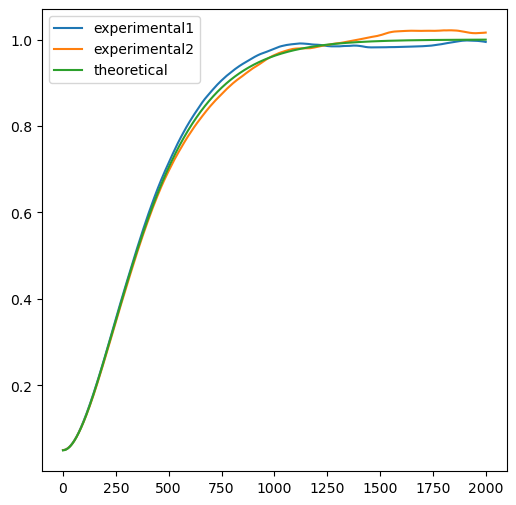

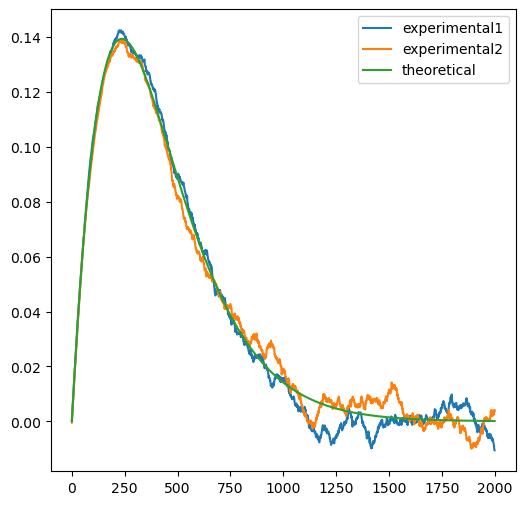

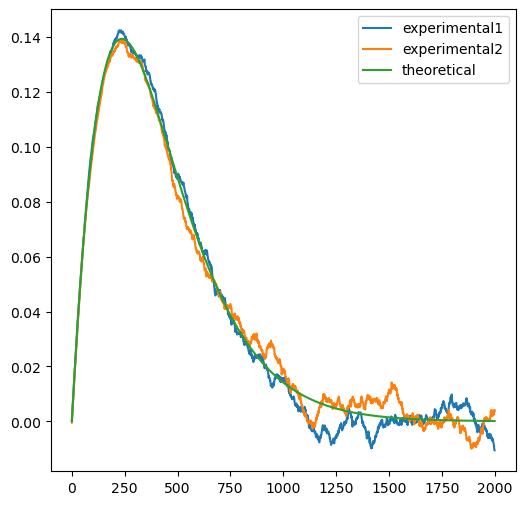

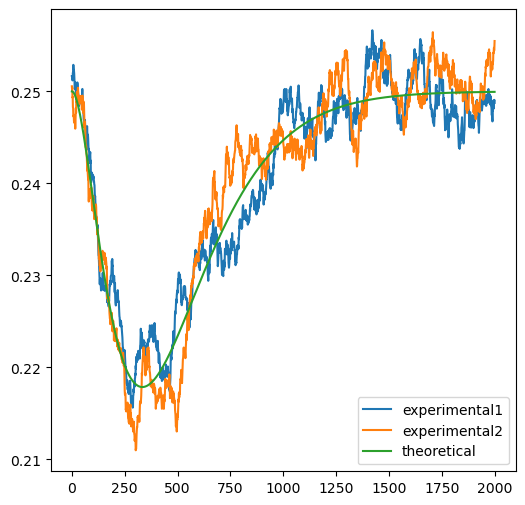

In [9]:
forward_covariances(jnp.array([0,0]), random.PRNGKey(7))

## TEST THE CROSS COVARIANCES 

In [10]:
# test : sanity check
t = jnp.array([0.2])
print(Sigma_xv(t))
print(Cov_xv(t,t))

print(Sigma_vv(t))
print(Cov_vv(t,t))

print(Sigma_xv(t))
print(Cov_vx(t,t))

print(Sigma_xx(t))
print(Cov_xx(t,t))

[0.11376031]
[0.11376032]
[0.21897444]
[0.21897446]
[0.11376031]
[0.11376031]
[0.5828789]
[0.5828788]


In [11]:
# Test : does the forward give the same covariance as predicted by our formulas 
experimental_batch_size = 10000

def forward_step(positions, stepSize, key) :
    """ 
    positions : (experimental_batch_size,2,2)
    stepSize : (experimental_batch_size)
    """ 
    positions = positions.reshape((experimental_batch_size,2,2))
    # TODO : accomodate for when f and G depend on time through beta
    f = jnp.array([[-Gamma,M**(-1) ], [ -1, -nu]])*beta/2
    G = jnp.array([[jnp.sqrt(Gamma*beta),0 ], [ 0 , jnp.sqrt(M*nu*beta)]])
    positions = positions + f@positions*stepSize[:,None,None] + G@(jnp.sqrt(stepSize[:,None,None])*random.normal(key, shape=positions.shape))
    return positions.reshape((experimental_batch_size,2,2))

def get_theoretical_cross_covariance(s, i ) :
    time_t_indices = i
    time_t = timeIndices2RealTime( time_t_indices )
    time_s = timeIndices2RealTime( s )
    
    return jnp.array([[Cov_xx(time_s,time_t),Cov_vx(time_s,time_t)],[Cov_xv(time_s,time_t) , Cov_vv(time_s,time_t)]])

def get_experimental_cross_covariance(positions1,positions2) :
    """ 
    positions : shape (experimental_batch_size,2,dim)
    """ 
    positions1 = positions1.transpose((0,2,1))
    positions1 = positions1 - jnp.mean(positions1, axis = 0)[None,...]

    positions2 = positions2.transpose((0,2,1))
    positions2 = positions2 - jnp.mean(positions2, axis = 0)[None,...]

    result = jnp.mean( positions1[...,None]@positions2[...,None,:] , axis = 0 )

    
    return result


def forward_cross_covariances(init_position, key) :
    """ 
    intput :
    - init_position : shape (2)
    """ 
    key, subkey1, subkey2 = random.split(key,3)
    experimental_cross_covariance_array = jnp.zeros(shape= (num_timesteps, 2, 2, 2))
    theoretical_cross_covariance_array = jnp.zeros(shape= (num_timesteps,2, 2))
    positions = jnp.zeros(shape = (num_timesteps, experimental_batch_size, 2,2) )
    positions = positions.at[0,:,0,:].set(init_position[None,:])

    # noise the input according to Sigma_0
    positions = positions.at[0,:,0,:].set(positions[0,:,0,:] + jnp.sqrt(Sigma_xx_0)*random.normal(subkey1, shape= positions[0,:,0,:].shape))
    positions = positions.at[0,:,1,:].set(positions[0,:,1,:] + jnp.sqrt(Sigma_vv_0)*random.normal(subkey2, shape= positions[0,:,1,:].shape))

    stepSize = timeSteps2stepSize(num_timesteps, experimental_batch_size)
    s_index = 500 # NOTE RANDOM

    for i in range(0,s_index):
        positions = positions.at[i+1].set( forward_step(positions[i],stepSize[i], key))
        key, = random.split(key,1)
    
    positions_ref_s = positions[s_index]

    for i in range(s_index,num_timesteps) :
        theoretical_cross_covariance_array = theoretical_cross_covariance_array.at[i].set(get_theoretical_cross_covariance(s_index,i))

        experimental_cross_covariance_array = experimental_cross_covariance_array.at[i].set(get_experimental_cross_covariance(positions_ref_s, positions[i]))

        positions = positions.at[i+1].set( forward_step(positions[i],stepSize[i], key))
        key, = random.split(key,1)

    plot_covariances_evolution(s_index,theoretical_cross_covariance_array, experimental_cross_covariance_array)

def plot_covariances_evolution(s_index,theoretical_cross_covariance_array, experimental_cross_covariance_array) :
    timesteps = list(range(num_timesteps))
    for k in range(2):
        for j in range(2):
            plt.figure(figsize=(6,6))
            plt.plot(timesteps, experimental_cross_covariance_array[:,0,k,j], label='experimental1')
            plt.plot(timesteps, experimental_cross_covariance_array[:,1,k,j], label='experimental2')
            plt.plot(timesteps, theoretical_cross_covariance_array[:,k,j], label='theoretical')
            plt.legend()
            plt.show()
    return


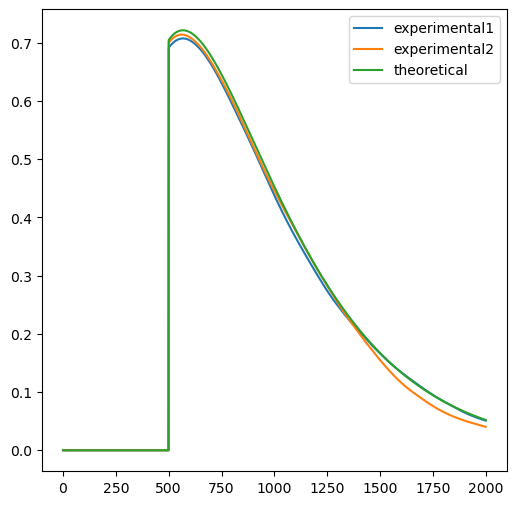

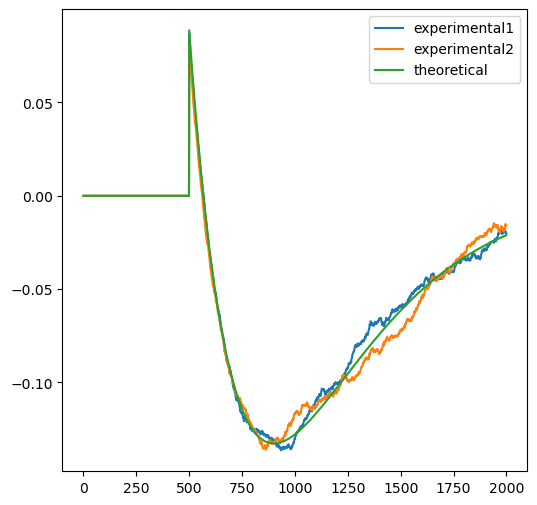

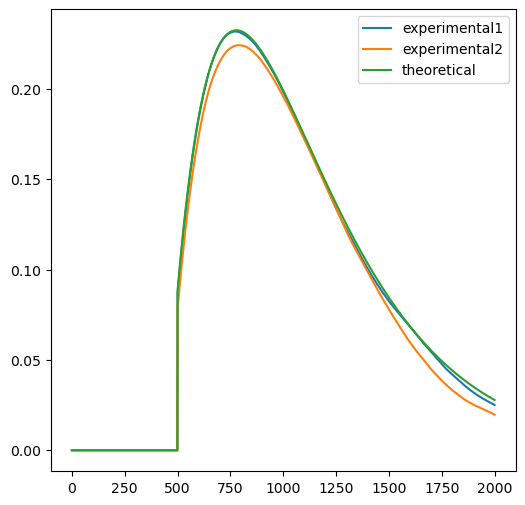

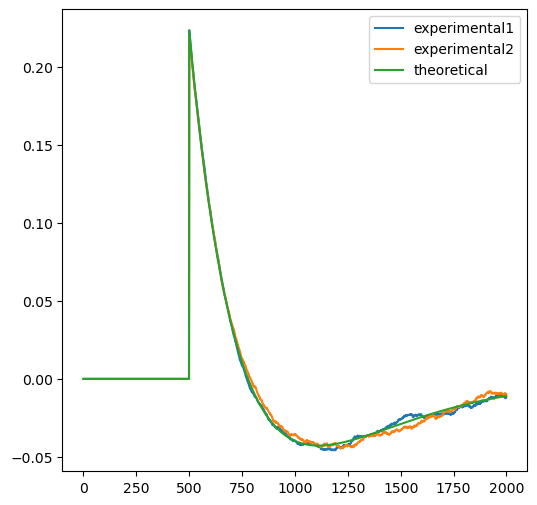

In [12]:
forward_cross_covariances(jnp.array([0,0]), random.PRNGKey(10))